# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

### Why We're Here 

To write an algorithm that will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling. An  example of the input. 

![Sample Dog Output](images/sample_dog_output.png)



### The Road Ahead

The notebook is broken into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): The Algorithm
* [Step 6](#step6): Test the Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets


In [1]:
import numpy as np
from glob import glob
from PIL import Image

# load filenames for human and dog images
human_files = np.array(glob("data/lfw/*/*"))
dog_files = np.array(glob("data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


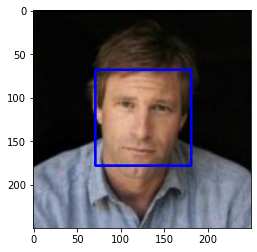

In [22]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [2]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [7]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]


## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

humanFile_check = list(map(face_detector,human_files_short))
dogFile_check = list(map(face_detector,dog_files_short))

print("Detected human faces percentage in human files: ", sum(humanFile_check)/len(humanFile_check))
print("Detected human faces percentage in dog files: ", sum(dogFile_check)/len(dogFile_check))

Detected human faces percentage in human files:  0.96
Detected human faces percentage in dog files:  0.17


In [7]:
dog_files_short[dogFile_check]

array(['data/dog_images\\test\\002.Afghan_hound\\Afghan_hound_00151.jpg',
       'data/dog_images\\test\\004.Akita\\Akita_00258.jpg',
       'data/dog_images\\test\\004.Akita\\Akita_00282.jpg',
       'data/dog_images\\test\\005.Alaskan_malamute\\Alaskan_malamute_00330.jpg',
       'data/dog_images\\test\\005.Alaskan_malamute\\Alaskan_malamute_00383.jpg',
       'data/dog_images\\test\\005.Alaskan_malamute\\Alaskan_malamute_00386.jpg',
       'data/dog_images\\test\\005.Alaskan_malamute\\Alaskan_malamute_00387.jpg',
       'data/dog_images\\test\\006.American_eskimo_dog\\American_eskimo_dog_00451.jpg',
       'data/dog_images\\test\\008.American_staffordshire_terrier\\American_staffordshire_terrier_00556.jpg',
       'data/dog_images\\test\\009.American_water_spaniel\\American_water_spaniel_00624.jpg',
       'data/dog_images\\test\\010.Anatolian_shepherd_dog\\Anatolian_shepherd_dog_00661.jpg',
       'data/dog_images\\test\\010.Anatolian_shepherd_dog\\Anatolian_shepherd_dog_00710.jpg'

Below we can see some of the pictures of dogs that the face_detector missclassified. We can see that some of the pictures actually had human faces.

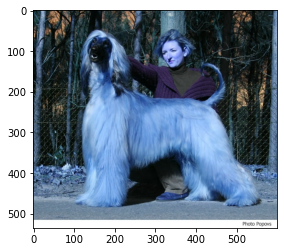

In [8]:
postive_face_dogfiles = dog_files_short[dogFile_check]
plt.imshow(cv2.imread(postive_face_dogfiles[0]))

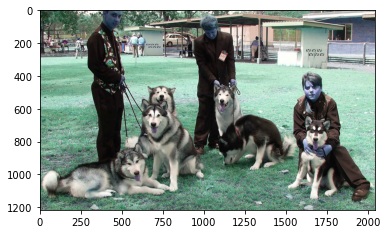

In [9]:
plt.imshow(cv2.imread(postive_face_dogfiles[6]))

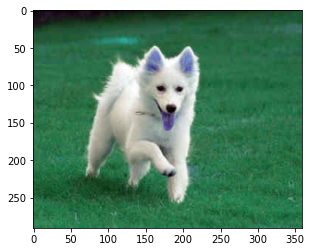

In [10]:
plt.imshow(cv2.imread(postive_face_dogfiles[7]))

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [3]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

In the next code cell, there  is a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

In [4]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path

    transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])])

    
    img = Image.open(img_path)
    img = transform(img)
    img = torch.unsqueeze(img, 0)
    
    # move model to GPU if CUDA is available    
    if use_cuda:
        img = img.to('cuda') 
        
    ## Return the *index* of the predicted class for that image          
    prediction = VGG16(img)
    
  
    return prediction.data.cpu().numpy().argmax()

### A Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

In [5]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    """Returns true if model detects a dog"""
    
    index = VGG16_predict(img_path)
    return (index>150) and (index<269)

###  Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [10]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

humanFile_check = list(map(dog_detector,human_files_short))
dogFile_check = list(map(dog_detector,dog_files_short))

print("Detected human faces percentage in human files: ", sum(humanFile_check)/len(humanFile_check))
print("Detected dogs percentage in dog files: ", sum(dogFile_check)/len(dogFile_check))

Detected human faces percentage in human files:  0.0
Detected dogs percentage in dog files:  0.95


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

 In this step, a CNN that classifies dog breeds is created from scratch.  

The task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  


###  Specify Data Loaders for the Dog Dataset



In [6]:
import os
from torchvision import datasets
from torchvision import transforms

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

###  Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
train_batch_size = 32
test_valid_batch_size = 16

train_transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.RandomGrayscale(p=0.1),
                                transforms.RandomRotation(180),
                                transforms.ColorJitter(brightness = 0.5),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                      [0.229, 0.224, 0.225])
                                ])

test_valid_transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
])
        
        
train = datasets.ImageFolder('data/dog_images/train', transform = train_transform)
valid = datasets.ImageFolder('data/dog_images/valid', transform = test_valid_transform)
test = datasets.ImageFolder('data/dog_images/test', transform = test_valid_transform)

# print out some data stats
print('Num training images: ', len(train))
print('Num test images: ', len(test))
print('Num validation images: ', len(valid))


train_loader = torch.utils.data.DataLoader(train,batch_size=train_batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid,batch_size=test_valid_batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test,batch_size= test_valid_batch_size, shuffle=False)

loaders_data = {'train':train_loader, 'valid':valid_loader, 'test':test_loader}

classes = train.classes
num_classes = len(classes)




Num training images:  6680
Num test images:  836
Num validation images:  835


In [7]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: 
After doing some research online. The trainning data was randomly resized and crop to size 224 X 224 X 3, randomly flipped horizontally. The test and validation datasets were resized to 256 X 256 X 3 and then croped to(224 X 224 X 3

### Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [10]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        ### Using (W−F+2P)/S+1
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)        
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)    
        self.conv3 = nn.Conv2d(32,64, 3, padding = 1)
        self.conv4 = nn.Conv2d(64,128, 3, padding = 1)
        self.conv5 = nn.Conv2d(128,256, 3, padding = 1)
        
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(256)
        
        # max pooling layers
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.pool5 = nn.MaxPool2d(2, 2)
        
        # dropout layer
        self.dropout1 = nn.Dropout(0.5)

        

        self.fc1 = nn.Linear(256 * 7 * 7, 512)

        # linear layer (256 * 7 * 7 -> n_classes (133))
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        

        x = self.pool1(F.relu(self.conv1(x)))
        x = self.bn1(x)

        x = self.pool2(F.relu(self.conv2(x)))
        x = self.bn2(x)
     
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.bn3(x)

        x = self.pool4(F.relu(self.conv4(x)))
        x = self.bn4(x)

        x = self.pool5(F.relu(self.conv5(x)))
        x = self.bn5(x)

    
            
            
        
        # flatten image input
        x = x.view(-1,256 * 7 * 7)        

        # add second hidden layer
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))

        return x



# instantiate the CNN
model_scratch = Net()


# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

There are five layers of convolution layers followed by a fully connected layer.

Each convolution layer consists of a Conv2d with stride = 1, kernal_size = 3 and padding = 1. Followed by 2*2 Max pooling layer and a BatchNorm2d layer with 16/32/64/128/256 filters.

This was followed by a fully connected linear layer. Then a dropout layer (p = 0.5) and the last fully connected linear layer.

In [20]:
from pytorch_model_summary import summary

print(summary(model_scratch, torch.zeros((32,3, 224, 224)), show_input=False))

--------------------------------------------------------------------------
      Layer (type)           Output Shape         Param #     Tr. Param #
          Conv2d-1     [32, 16, 224, 224]             448             448
       MaxPool2d-2     [32, 16, 112, 112]               0               0
     BatchNorm2d-3     [32, 16, 112, 112]              32              32
          Conv2d-4     [32, 32, 112, 112]           4,640           4,640
       MaxPool2d-5       [32, 32, 56, 56]               0               0
     BatchNorm2d-6       [32, 32, 56, 56]              64              64
          Conv2d-7       [32, 64, 56, 56]          18,496          18,496
       MaxPool2d-8       [32, 64, 28, 28]               0               0
     BatchNorm2d-9       [32, 64, 28, 28]             128             128
         Conv2d-10      [32, 128, 28, 28]          73,856          73,856
      MaxPool2d-11      [32, 128, 14, 14]               0               0
    BatchNorm2d-12      [32, 128, 14,

In [21]:
from pytorch_model_summary import summary

print(summary(model_scratch, torch.zeros((32,3, 224, 224)), show_input=True))

--------------------------------------------------------------------------
      Layer (type)            Input Shape         Param #     Tr. Param #
          Conv2d-1      [32, 3, 224, 224]             448             448
       MaxPool2d-2     [32, 16, 224, 224]               0               0
     BatchNorm2d-3     [32, 16, 112, 112]              32              32
          Conv2d-4     [32, 16, 112, 112]           4,640           4,640
       MaxPool2d-5     [32, 32, 112, 112]               0               0
     BatchNorm2d-6       [32, 32, 56, 56]              64              64
          Conv2d-7       [32, 32, 56, 56]          18,496          18,496
       MaxPool2d-8       [32, 64, 56, 56]               0               0
     BatchNorm2d-9       [32, 64, 28, 28]             128             128
         Conv2d-10       [32, 64, 28, 28]          73,856          73,856
      MaxPool2d-11      [32, 128, 28, 28]               0               0
    BatchNorm2d-12      [32, 128, 14,

###  Specify Loss Function and Optimizer


In [11]:
import torch.optim as optim

### select loss function
criterion_scratch = nn.CrossEntropyLoss()

# specify optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)


###  Train and Validate the Model

Train and validate the model. The final model is saved ) at filepath `'model_scratch.pt'`.

In [13]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        correct = 0.0
        
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like


            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item() * data.size(0)
            

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx,(data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item() * data.size(0)
            predictions = output.data.max(1, keepdim=True)[1]
            correct += np.sum(np.squeeze(predictions.eq(target.data.view_as(predictions))).cpu().numpy())
        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)
        acc = correct/len(valid_loader.dataset)
    
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Acc: {:.3f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            acc
            ))
        
        ##  save the model if validation loss has decreased
            # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model


# train the model

n_epochs = 50
loaders_scratch = loaders_data


model_scratch = train(n_epochs, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.859159 	Validation Loss: 4.732491 	Validation Acc: 0.030
Validation loss decreased (inf --> 4.732491).  Saving model ...
Epoch: 2 	Training Loss: 4.709540 	Validation Loss: 4.576967 	Validation Acc: 0.049
Validation loss decreased (4.732491 --> 4.576967).  Saving model ...
Epoch: 3 	Training Loss: 4.606450 	Validation Loss: 4.475935 	Validation Acc: 0.057
Validation loss decreased (4.576967 --> 4.475935).  Saving model ...
Epoch: 4 	Training Loss: 4.509179 	Validation Loss: 4.356873 	Validation Acc: 0.065
Validation loss decreased (4.475935 --> 4.356873).  Saving model ...
Epoch: 5 	Training Loss: 4.399056 	Validation Loss: 4.299117 	Validation Acc: 0.063
Validation loss decreased (4.356873 --> 4.299117).  Saving model ...
Epoch: 6 	Training Loss: 4.295684 	Validation Loss: 4.232150 	Validation Acc: 0.075
Validation loss decreased (4.299117 --> 4.232150).  Saving model ...
Epoch: 7 	Training Loss: 4.200748 	Validation Loss: 4.091686 	Validation Acc: 0.084
Val

<All keys matched successfully>

### Test the Model

In [38]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.328066


Test Accuracy: 23% (197/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)



### Specify Data Loaders for the Dog Dataset


In [12]:
## TODO: Specify data loaders
loaders_transfer = loaders_data

### Model Architecture


In [13]:
## TODO: Specify model architecture 
model_transfer =  models.vgg16(pretrained=True)

# print out the model structure
print("Model\n",model_transfer)

in_features = model_transfer.classifier[6].in_features
out_features = num_classes

print("Features in: ",model_transfer.classifier[6].in_features) 
print("Features out: ",model_transfer.classifier[6].out_features) 

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    


Model
 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dil

In [14]:
import torchvision.models as models
import torch.nn as nn

model_transfer.classifier[6] = nn.Linear(in_features,out_features)

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 
Transfer learning allows for the repurposing taking a pre-trained neural network and applying it to a new data set. 

###  Specify Loss Function and Optimizer


In [17]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer .classifier.parameters(), lr=0.001)

###  Train and Validate the Model

Train and validate your model and save model at filepath `'model_transfer.pt'`.

In [18]:
# train the model
n_epochs = 20

model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
#model_transfer.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.824956 	Validation Loss: 4.373305 	Validation Acc: 0.133
Validation loss decreased (inf --> 4.373305).  Saving model ...
Epoch: 2 	Training Loss: 4.385162 	Validation Loss: 3.735091 	Validation Acc: 0.305
Validation loss decreased (4.373305 --> 3.735091).  Saving model ...
Epoch: 3 	Training Loss: 3.906493 	Validation Loss: 2.989377 	Validation Acc: 0.478
Validation loss decreased (3.735091 --> 2.989377).  Saving model ...
Epoch: 4 	Training Loss: 3.390482 	Validation Loss: 2.279437 	Validation Acc: 0.588
Validation loss decreased (2.989377 --> 2.279437).  Saving model ...
Epoch: 5 	Training Loss: 3.028529 	Validation Loss: 1.792725 	Validation Acc: 0.642
Validation loss decreased (2.279437 --> 1.792725).  Saving model ...
Epoch: 6 	Training Loss: 2.730359 	Validation Loss: 1.477784 	Validation Acc: 0.680
Validation loss decreased (1.792725 --> 1.477784).  Saving model ...
Epoch: 7 	Training Loss: 2.534274 	Validation Loss: 1.283349 	Validation Acc: 0.699
Val

In [15]:
# load the model if cuda is unavailable
#model_transfer.load_state_dict(torch.load('model_transfer.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

### Test the Model


In [44]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.648065


Test Accuracy: 80% (671/836)


###  Predict Dog Breed with the Model
 

In [16]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in classes]

def predict_breed_transfer(img_path):
    """Takes a path to an image as input
     and returns the dog breed that is predicted by the model."""
    
    # load the image and return the predicted breed

    img = Image.open(img_path)
    
    
    transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
        
    img = transform(img)
    img = img.unsqueeze(0)
    if use_cuda:
        img = img.to('cuda') 
        
    prediction = model_transfer(img)
        
    idx = prediction.data.cpu().numpy().argmax()
    class_name = class_names[idx]
        
    return class_name, classes[idx]

---
<a id='step5'></a>
## Step 5: The Algorithm

The algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.



Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


In [17]:

import os
import random

def run_app(img_path):
    
    class_name, dir_name = predict_breed_transfer(img_path)
    pic = random.choice(os.listdir(f'data/dog_images/train/{dir_name}'))
    if dog_detector(img_path):

        print(f"Hey is a {class_name}")
        img = Image.open(img_path)
        plt.imshow(img)
        plt.show()
        if class_name != dir_name.split('.')[-1].replace("_"," "):
            print(f"Actually its a {dir_name.split('.')[-1]}")

        
    elif face_detector(img_path):
    
        print("Its ALiVe!!!! Sorry I mean human")
        img = Image.open(img_path)
        plt.imshow(img)
        plt.show()        

        print("You look like")
        img = Image.open(os.path.join(f'data/dog_images/train/{dir_name}',pic))
        plt.imshow(img)
        plt.show() 
    else:
        print("Ok I have no clue what THAT is")
        img = Image.open(img_path)
        plt.imshow(img)
        plt.show()

---
<a id='step6'></a>
## Step 6: Test The Algorithm 

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__  
The output is better than I expected.
Improvements:  
1) Train model_transfer for more epochs as the losses were still decreasing.  
2) Try different data augumentation methods so the model to generalize better  
3) Try different learning rates and optimizers   

In [18]:
test = np.array(glob("data/run_app_test/*/*"))

Its ALiVe!!!! Sorry I mean human


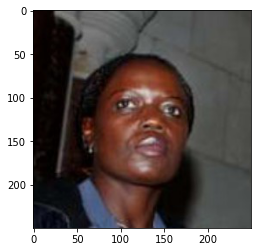

You look like


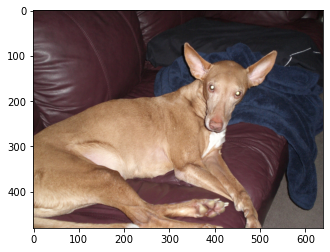

Its ALiVe!!!! Sorry I mean human


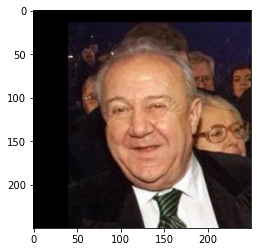

You look like


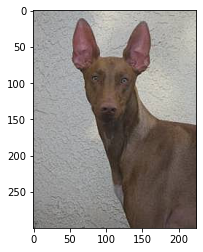

Its ALiVe!!!! Sorry I mean human


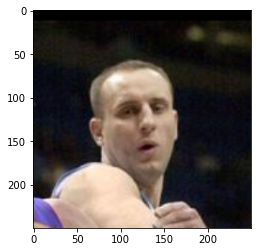

You look like


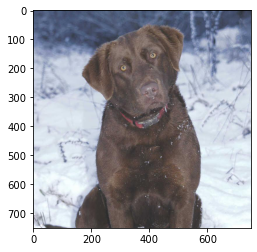

Hey is a Boxer


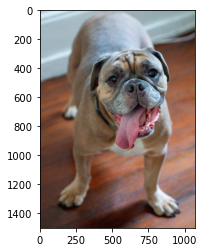

Hey is a Chihuahua


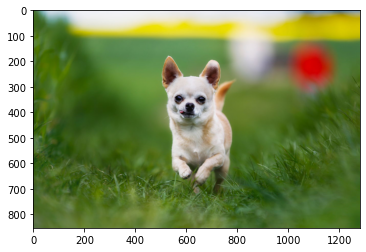

Hey is a Great dane


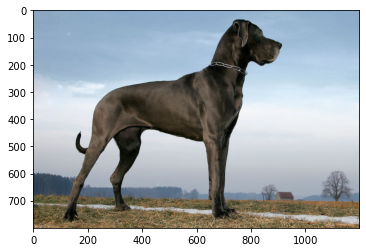

In [24]:
for file in np.hstack((human_files[-3:], test)):
    run_app(file)